# Get the interpolated precession data

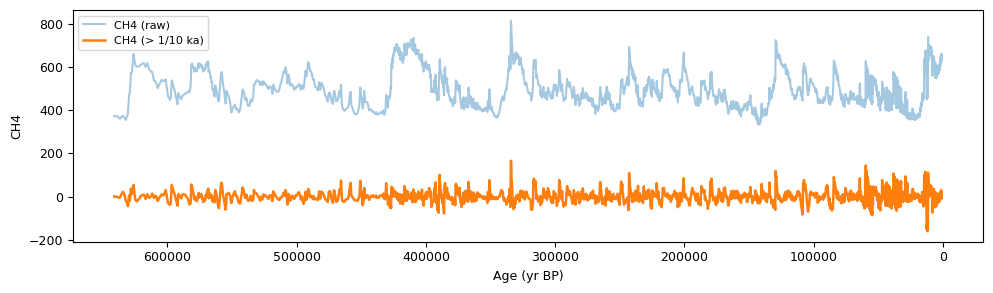

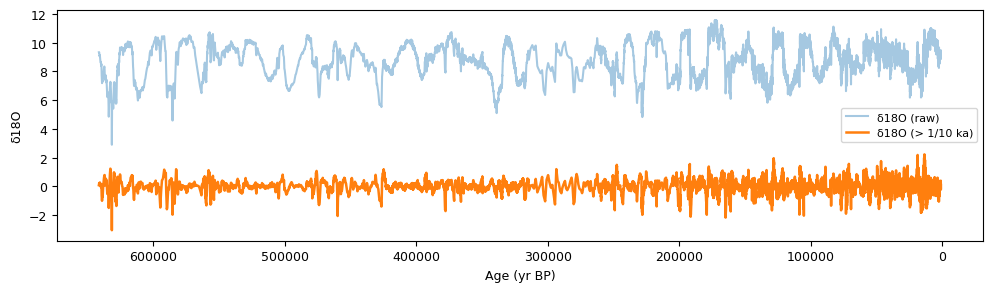

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


# 0) Load raw data
df_ch4 = pd.read_excel('other_data/CH4_AICC2023.xlsx', sheet_name='Sheet1')
file_path = r"D:\VScode\bipolar_seesaw_CCM\other_data\monsoon.xlsx"
df_d18O = pd.read_excel(file_path)
df_d18O['age'] *= 1000  # to yrs BP
df_d18O['d18O'] = df_d18O['d18O'].values*-1
# renmae column d18O to 'd18O*-1'
df_d18O.rename(columns={'d18O': '-d18O'}, inplace=True)

dt=10
# 1) Build common 10-yr age grid over their overlap
age_min = 1000 # max(df_ch4['age'].min(), df_d18O['age'].min())
age_max = min(df_ch4['age'].max(), df_d18O['age'].max())
ages = np.arange(age_min, age_max + 1, dt)

# 2) Interpolate each onto that grid
ch4 = np.interp(ages, df_ch4['age'], df_ch4['ch4'])
d18O = np.interp(ages, df_d18O['age'], df_d18O['-d18O'])



df_ch4_interp = pd.DataFrame({'age':ages, 'ch4':ch4})
df_d18O_interp = pd.DataFrame({'age':ages, 'd18O':d18O})

df_filt_ch4, df_filt_d18O = sa.highpass_ch4_d18O(
    df_ch4_interp,          # DataFrame with columns ['age','ch4']
    df_d18O_interp,         # columns ['age','d18O']
    cutoff_period = 10000, # high-pass >1/10 ka
    plot = True             # quick comparison plot
)


df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_ch4.copy(), 50, if_plot=False)



# Create base signal

Number of 0 → 1 transitions: 299
Number of 1 → 0 transitions: 300
Total number of events: 299


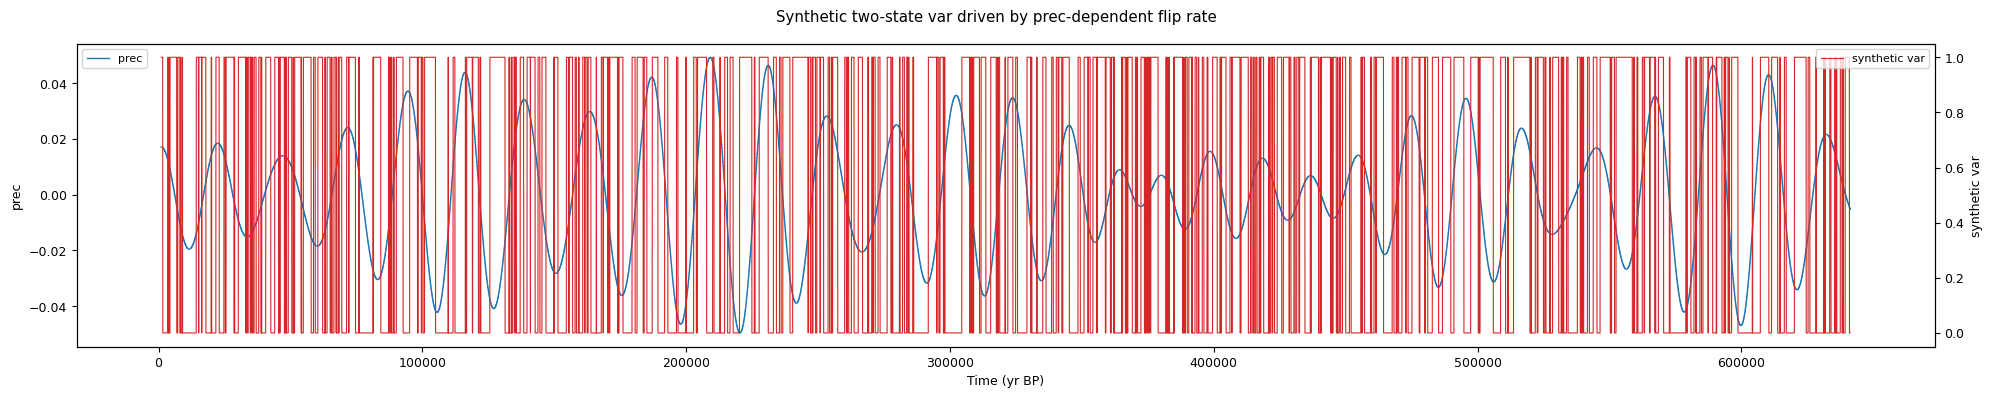

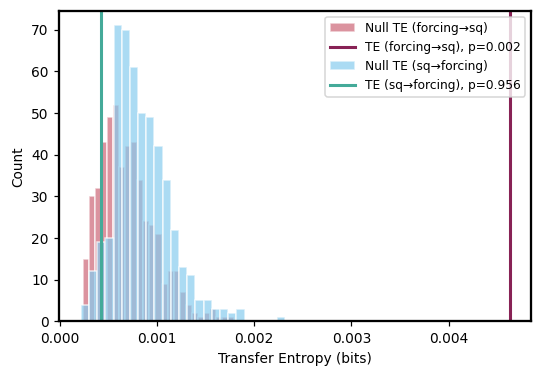


Unidirectional significance (prec → var only)?  True


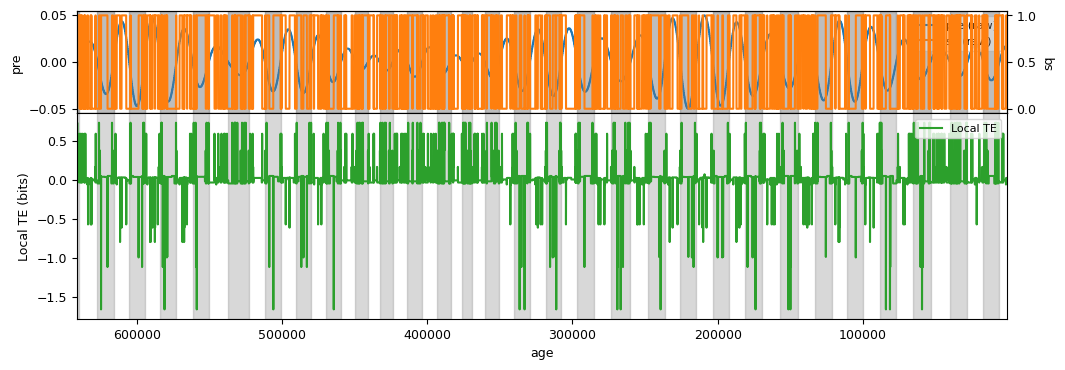

First 10 local-TE values: [[-0.04781899 -0.04781899 -0.04781899 ...  0.02277037  0.02277037
   0.02277037]]


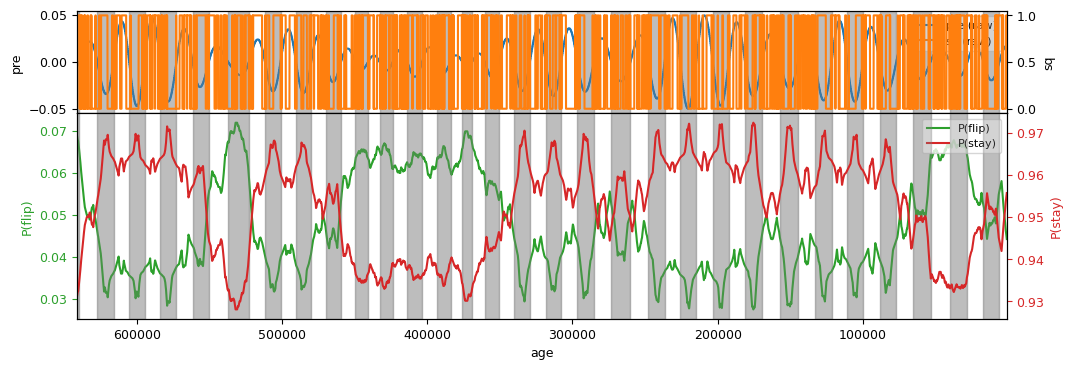

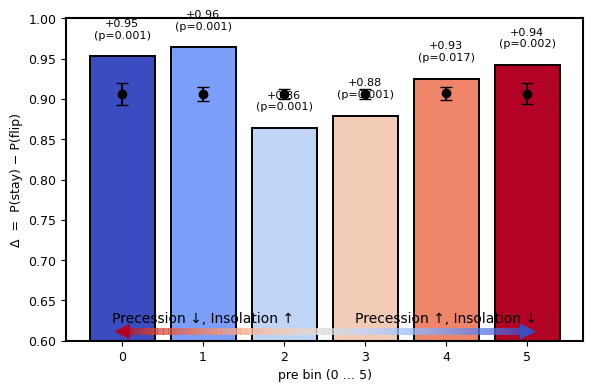

In [21]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt






prec = df_pre_i['pre'].values      # source (precession)
time = df_pre_i['age'].values      # time axis (yr BP)







np.random.seed(2025)

state_amp   = 1.0      # |value| when above / below zero
noise_sd    = 0     # small jitter around ±state_amp
# # baseline flip probability → mean recurrence time of 1400 yr
# p_base      = 1.0 / 28
# # high- and low-flip probabilities (favoured / suppressed windows)
# p_hi        = 1.0 / 14     # mean recurrence time 700 yr
# p_lo        = 1.0 / 56    # mean recurrence time 2800 yr




# baseline flip probability → mean recurrence time of 1470 yr
p_base      = 1.0 / 29
# high- and low-flip probabilities (favoured / suppressed windows)
p_hi        = 1.0 / 15     # mean recurrence time 700 yr
p_lo        = 1.0 / 59    # mean recurrence time 2900 yr




# p_base      = 1.0 / 25
# # high- and low-flip probabilities (favoured / suppressed windows)
# p_hi        = 1.0 / 17     # mean wait ≈50 points
# p_lo        = 1.0 / 34    # mean wait ≈200 points

# ---------------------------------------------------------------
# 2.  NORMALISE prec TO [0, 1] AND DEFINE THE WINDOWS
# ---------------------------------------------------------------
prec_norm = (prec - prec.min()) / (prec.max() - prec.min())

def flip_prob(pn):
    """
    Piece-wise flip probability as a function of normalised prec.
    """
    if pn <= 2/6:
        return p_lo         # suppressed flipping
    elif 2/6 < pn <= 4/6:
        return p_hi         # favoured flipping
    else:
        return p_base       # default

# ---------------------------------------------------------------
# 3.  SYNTHETIC var:  TWO-STATE MARKOV WITH prec-MODULATED FLIPS
# ---------------------------------------------------------------
N = len(prec)
var = np.zeros(N)

state = 1.0                        # start in the “warm” (+) state
for i in range(N):
    # store current state with a dash of white noise
    var[i] = state + np.random.normal(scale=noise_sd)
    # decide whether to flip for next time step
    if np.random.rand() < flip_prob(prec_norm[i]):
        state = -state               # flip 

# replace all -1 in var with 0
var[var < 0] = 0

# print the number of 0-1 and 1-0 transitions
transitions = np.diff(var)
num_01 = np.sum(transitions == 1)  # 0 → 1 transitions
num_10 = np.sum(transitions == -1) # 1 → 0 transitions
print(f"Number of 0 → 1 transitions: {num_01}")
print(f"Number of 1 → 0 transitions: {num_10}")

N_EVENTS = int(0.5*(num_01 + num_10))  # total number of events
print(f"Total number of events: {N_EVENTS}")

fig, ax1 = plt.subplots(figsize=(20, 4))
ax2 = ax1.twinx()

ax1.plot(time, prec, lw=1, label='prec')
ax2.plot(time, var,  color='tab:red', lw=0.8, label='synthetic var')

ax1.set_xlabel('Time (yr BP)')
ax1.set_ylabel('prec')
ax2.set_ylabel('synthetic var')
fig.suptitle('Synthetic two-state var driven by prec-dependent flip rate')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 5.  TRANSFER-ENTROPY ANALYSIS (series reversed for MATLAB style)
# ---------------------------------------------------------------
from toolbox import sq_ana as sa
import importlib; importlib.reload(sa)

# forcing = prec[::-1]     # driver  (prec)
# sq      = var[::-1]      # target  (synthetic var)
# time    = time[::-1]    # reverse time to match MATLAB's direction

forcing = prec
sq      = var

delta_T=50 # should smaller than the 1/2 of the recurrence period of the MCV

new_time = np.arange(np.min(time), np.max(time) + 1, delta_T)
forcing = np.interp(new_time, time, forcing)
sq      = np.interp(new_time, time, sq)
time = new_time


# 5.1  Surrogate-test TE (global)
unidir_prec_to_var, fig_te, te_pre = sa.transfer_entropy_surrogate_test(
    forcing      = forcing,
    sq           = sq,
    k            = 1,
    forcing_bins = 7,
    sq_bins      = 2,
    n_surr       = 500,
    p            = 0.05,
    sq_method    = 'hist',
    if_plot      = True,
    dpi          = 110
)
print("\nUnidirectional significance (prec → var only)? ",
      unidir_prec_to_var)

# 5.2  Local-TE track
df_pre = pd.DataFrame({"age": time, "pre": forcing})
df_sq  = pd.DataFrame({"age": time, "sq":  sq})

local_te_vals = sa.local_TE(
    df_pre          = df_pre,
    df_sq           = df_sq,
    forcing_column  = "pre",
    target_column   = "sq",
    time_column     = "age",
    nbins_pre       = 6,
    nbins_target    = 2
)
print("First 10 local-TE values:", local_te_vals[:10])

Lp = sa.local_prob(df_pre.copy(), df_sq.copy(),
                   forcing_column='pre',
                   target_column='sq',
                   time_column='age',
                   nbins_pre=6,
                   smooth_win=300)



delta, mu, sigma, p = sa.prob_prebins_diffbar_surr(
        df_pre, df_sq,
        forcing_column='pre',
        target_column='sq',
        nbins_pre=6,
        n_surr=1000,
        alpha=0.05,
        random_state=0   # reproducible
)




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  48 out of 100 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  59 out of 100 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  70 out of 100 | elapsed:    2.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  81 out of 100 | elapsed:    2.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  92 out of 100 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4

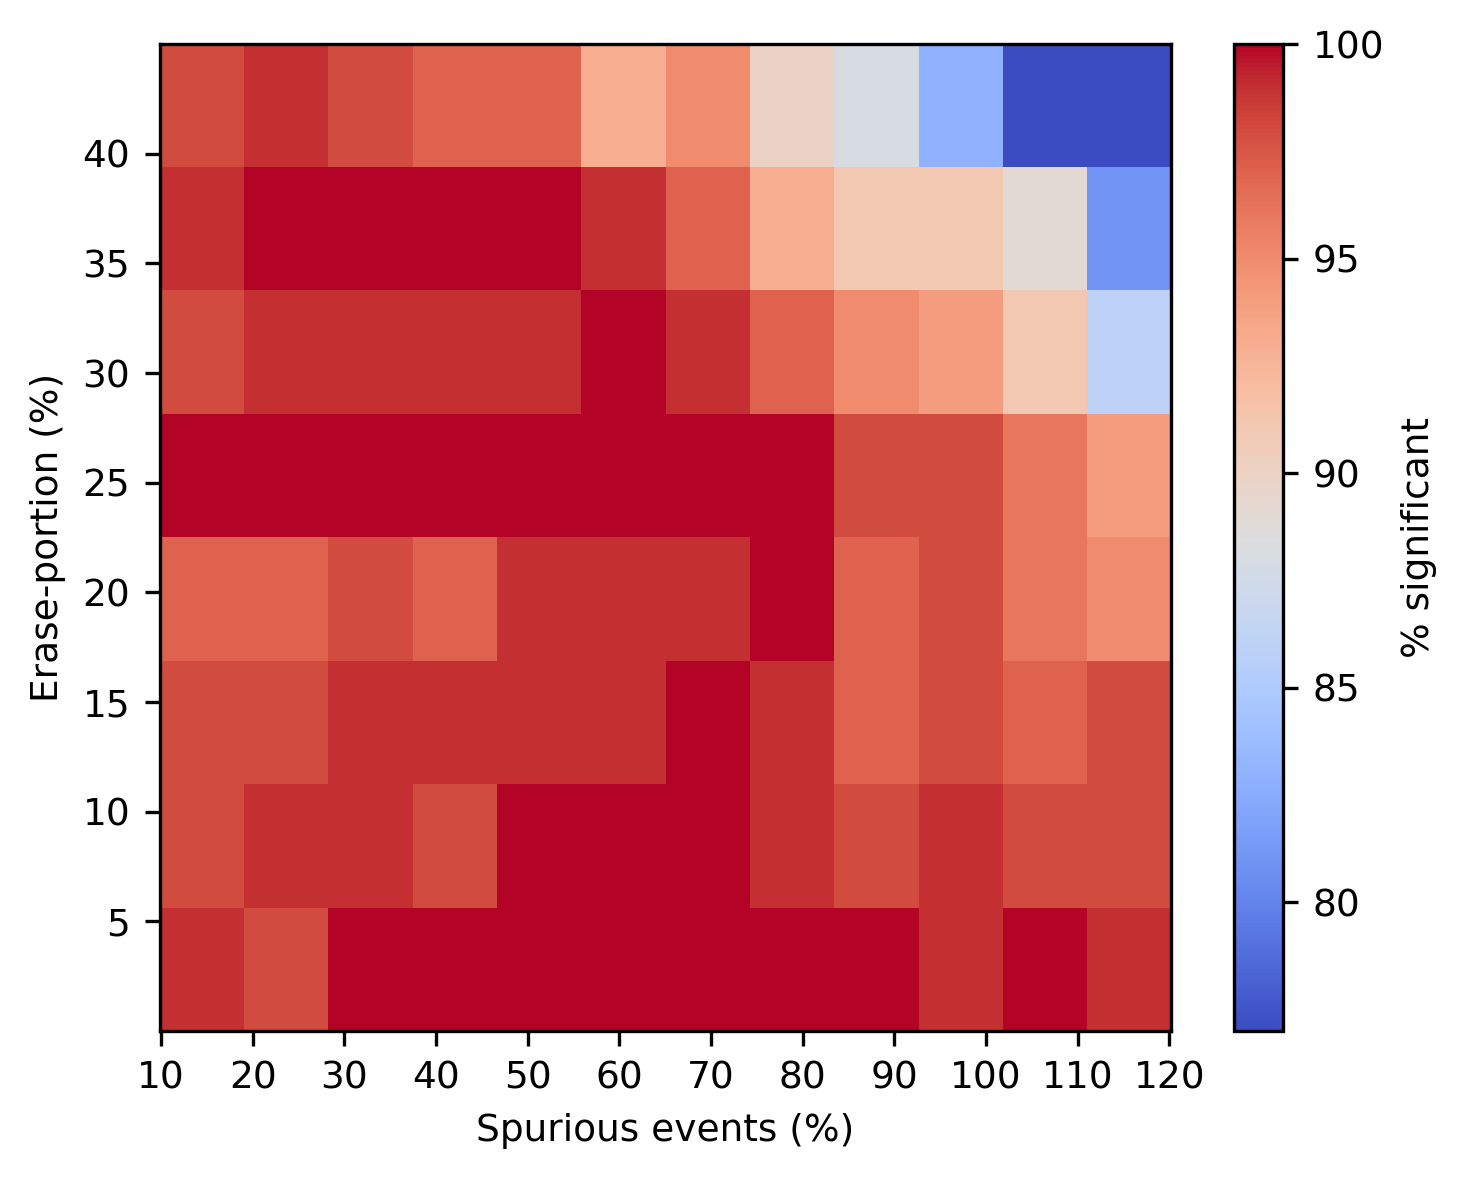

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from toolbox import syn_test as syn_t
from toolbox import sq_ana  as sa
import importlib
importlib.reload(syn_t)
importlib.reload(sa)

from joblib import Parallel, delayed

# ───────────────────────────────────────────────
# parameters
n_iter        = 100
# base_No = 250
base_No = N_EVENTS
# n_events_list = list(range(75, 251, 25))
n_events_list = list(range(int(0.1*base_No), int(1.25*base_No), 30))
erase_list    = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
forcing_bins  = 6
sq_bins       = 2
sq_method     = 'quantile'
binary        = True
n_surr        = 1000

pre = df_pre_i['pre'].values
# ───────────────────────────────────────────────

def _run_once(erase_portion: float, n_events: int, seed: int) -> bool:
    """Do one replicate: perturb & TE-test; return True if significant."""
    df_pert, _ = syn_t.perturb_sequence_random_erase(
        df_sq,
        n_events=n_events,
        min_len=2, max_len=10,
        trans_shift=4,
        erase_portion=erase_portion,
        random_state=seed,
        plot=False
    )
    sq = df_pert['sq'].values

    sig, *_ = sa.transfer_entropy_surrogate_test(
        pre, sq,
        forcing_bins=forcing_bins,
        sq_bins=sq_bins,
        sq_method=sq_method,
        binary=binary,
        n_surr=n_surr,
        if_plot=False,
    )
    return bool(sig)

def compute_heatmap():
    percent_sig = np.zeros((len(erase_list), len(n_events_list)))

    # Create one Parallel pool for the whole grid.
    # verbose=10 → print progress every ~10 tasks
    parallel = Parallel(n_jobs=-1, backend="loky", verbose=10)

    for i, erase_portion in enumerate(erase_list):
        for j, n_events in enumerate(n_events_list):
            # dispatch all seeds for this cell
            seeds = range(n_iter)
            results = parallel(
                delayed(_run_once)(erase_portion, n_events, seed)
                for seed in seeds
            )
            percent_sig[i, j] = 100 * np.mean(results)

    return percent_sig


percent_sig = compute_heatmap()




fig, ax = plt.subplots(figsize=(5, 4), dpi=300)

im = ax.imshow(
    percent_sig,
    origin='lower',
    aspect='auto',
    cmap='coolwarm',
    extent=[
        min(n_events_list) - 0.5,
        max(n_events_list) + 0.5,
        min(erase_list)   - 0.05,
        max(erase_list)   + 0.05
    ],
)

# X-tick labels as % of the baseline number of events
ax.set_xticks(n_events_list)
ax.set_xticklabels([f"{n/base_No*100:.0f}" for n in n_events_list])

# Y-tick labels as %
ax.set_yticks(erase_list)
ax.set_yticklabels([f"{e*100:.0f}" for e in erase_list])

ax.set_xlabel('Spurious events (%)')
ax.set_ylabel('Erase-portion (%)')
# ax.set_title('% significant TE over perturbations')

fig.colorbar(im, ax=ax, label='% significant')
fig.tight_layout()

# ---- save first, then show -----------------------------------
fig.savefig("Figures/syn_data_heatmap.pdf",
            bbox_inches='tight', dpi=300)

plt.show()
plt.close(fig)          # optional housekeeping



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  

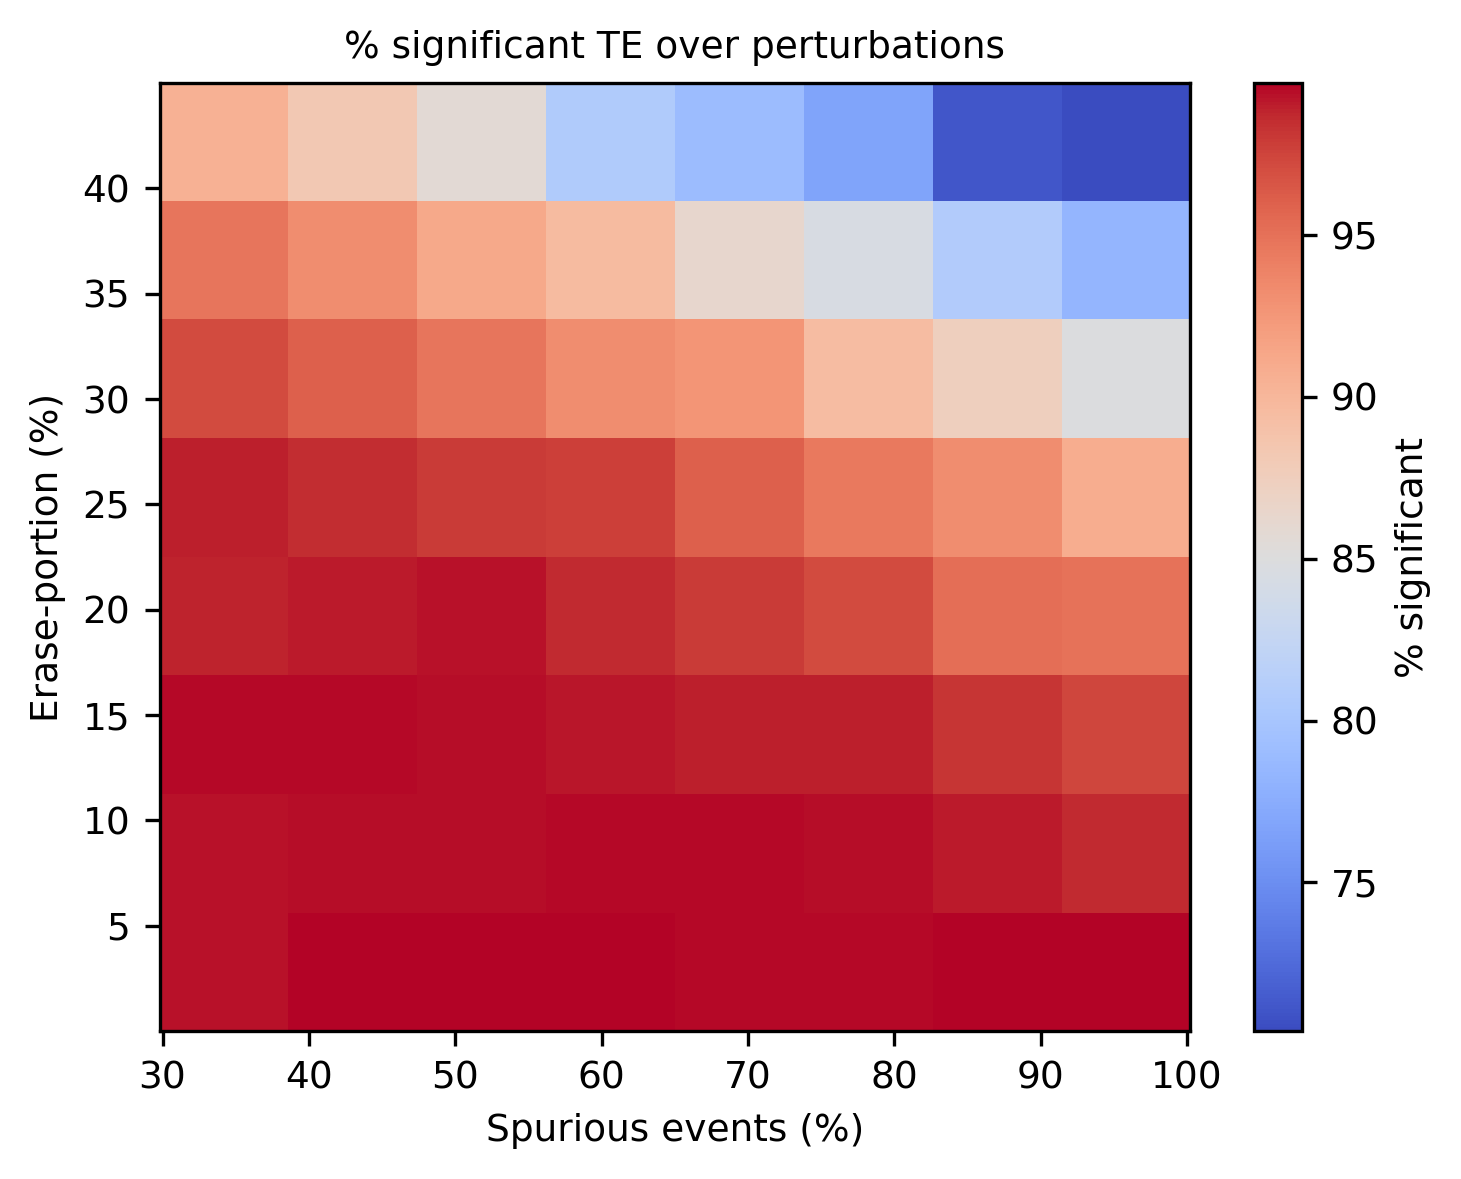

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from toolbox import syn_test as syn_t
from toolbox import sq_ana  as sa
import importlib
importlib.reload(syn_t)
importlib.reload(sa)

from joblib import Parallel, delayed

# ───────────────────────────────────────────────
# parameters
n_iter        = 1000
n_events_list = list(range(75, 251, 25))
erase_list    = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
forcing_bins  = 6
sq_bins       = 2
sq_method     = 'quantile'
binary        = True
n_surr        = 1000

pre = df_pre_i['pre'].values
# ───────────────────────────────────────────────

def _run_once(erase_portion: float, n_events: int, seed: int) -> bool:
    """Do one replicate: perturb & TE-test; return True if significant."""
    df_pert, _ = syn_t.perturb_sequence_random_erase(
        df_sq,
        n_events=n_events,
        min_len=2, max_len=10,
        trans_shift=4,
        erase_portion=erase_portion,
        random_state=seed,
        plot=False
    )
    sq = df_pert['sq'].values

    sig, *_ = sa.transfer_entropy_surrogate_test(
        pre, sq,
        forcing_bins=forcing_bins,
        sq_bins=sq_bins,
        sq_method=sq_method,
        binary=binary,
        n_surr=n_surr,
        if_plot=False,
    )
    return bool(sig)

def compute_heatmap():
    percent_sig = np.zeros((len(erase_list), len(n_events_list)))

    # Create one Parallel pool for the whole grid.
    # verbose=10 → print progress every ~10 tasks
    parallel = Parallel(n_jobs=-1, backend="loky", verbose=10)

    for i, erase_portion in enumerate(erase_list):
        for j, n_events in enumerate(n_events_list):
            # dispatch all seeds for this cell
            seeds = range(n_iter)
            results = parallel(
                delayed(_run_once)(erase_portion, n_events, seed)
                for seed in seeds
            )
            percent_sig[i, j] = 100 * np.mean(results)

    return percent_sig


percent_sig = compute_heatmap()

base_No = 250


fig, ax = plt.subplots(figsize=(5, 4), dpi=300)

im = ax.imshow(
    percent_sig,
    origin='lower',
    aspect='auto',
    cmap='coolwarm',
    extent=[
        min(n_events_list) - 0.5,
        max(n_events_list) + 0.5,
        min(erase_list)   - 0.05,
        max(erase_list)   + 0.05
    ],
)

# X-tick labels as % of the baseline number of events
ax.set_xticks(n_events_list)
ax.set_xticklabels([f"{n/base_No*100:.0f}" for n in n_events_list])

# Y-tick labels as %
ax.set_yticks(erase_list)
ax.set_yticklabels([f"{e*100:.0f}" for e in erase_list])

ax.set_xlabel('Spurious events (%)')
ax.set_ylabel('Erase-portion (%)')
ax.set_title('% significant TE over perturbations')

fig.colorbar(im, ax=ax, label='% significant')
fig.tight_layout()

# ---- save first, then show -----------------------------------
fig.savefig("Figures/syn_data_heatmap.pdf",
            bbox_inches='tight', dpi=300)

plt.show()
plt.close(fig)          # optional housekeeping

# # --- plot heatmap ---
# plt.figure(figsize=(5, 4), dpi=300)
# im = plt.imshow(
#     percent_sig, origin='lower', aspect='auto', cmap='coolwarm',
#     extent=[min(n_events_list)-0.5, max(n_events_list)+0.5,
#             min(erase_list)-0.05,  max(erase_list)+0.05]
# )

# # set both the tick positions *and* their labels in one go
# plt.xticks(
#     ticks=n_events_list,
#     labels=[f"{(n/base_No)*100:.0f}" for n in n_events_list]
# )

# plt.yticks(erase_list, 
#            labels=[f"{e*100:.0f}" for e in erase_list])
# plt.ylabel('Erase-portion (%)')
# plt.xlabel('Spurious events (%)')
# # plt.ylabel('Erase-portion')
# plt.title('% significant TE over perturbations')
# plt.colorbar(im, label='% significant')
# plt.grid(False)
# plt.tight_layout()
# plt.show()
